# Hierarchical Clustering

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score
import sys
sys.path.append('../')
from utils import center_and_scale
from matplotlib import pyplot as plt

## Cyclist Dataset

In [2]:
cyclist_df = pd.read_csv('../dataset/cyclists_outlier.csv')

### Preprocessing

In [3]:
columns_to_keep = ["avg_relative_position", "mean_sq", "career_level"]

# drop the unnecessary columns for the clustering and keep only the numerical columns 
numerical_cyclists_df = cyclist_df[columns_to_keep]
numerical_cyclists_df

,avg_relative_position,mean_sq,career_level
0,0.004726,1615.878378,14371.866873
1,0.010415,775.122449,1514.222579
2,0.007259,1052.086957,8115.442081
3,0.009004,784.895833,1673.263534
4,0.008623,972.963542,11460.308567
...,...,...,...
3471,0.005587,1021.305648,13654.562144
3472,0.007723,863.183673,2179.182843
3473,0.006247,1164.818182,858.492493
3474,0.012301,676.653846,787.168167


We normalize the data.

In [4]:
scaler = StandardScaler()
scaler = scaler.fit(numerical_cyclists_df)
scaled_cyclists_df = scaler.transform(numerical_cyclists_df)

### Clustering 
We perform the agglomerative hirarchical clustering.

In [5]:
results = []
for metric in ['cityblock','correlation', 'cosine', 'euclidean']:
    methods = ['complete','single','average','weighted']
    if metric == 'euclidean':
        methods += ['ward','median','centroid']
    for method in methods:
        for k in [3, 4, 5, 6, 10]:
            distances = pdist(scaled_cyclists_df, metric=metric)
            dlinkage = linkage(distances, metric=metric, method=method)
            labels = fcluster(dlinkage,k,criterion='maxclust')
            silhouette = silhouette_score(scaled_cyclists_df, labels)
            bouldin = davies_bouldin_score(scaled_cyclists_df, labels)
            #print(f"metric: {metric}, method:{method}, level':{level}, k:{k}, silhouette: {silhouette} , DBscore:{bouldin}")
            results.append({'metric':metric, 'method':method, 'k':k, 'silhouette': silhouette, 'DBscore':bouldin})

results_df = pd.DataFrame(results)

In [6]:
# Order the results by the best silhouette score and then by the highest DB score if silhouette scores are the same
results_df.sort_values(by=['silhouette', 'DBscore'], ascending=[False, True], inplace=True)

# show results
results_df.head(20)


,metric,method,k,silhouette,DBscore
60,euclidean,complete,3,0.399283,0.785226
80,euclidean,ward,3,0.387230,0.815282
15,cityblock,weighted,3,0.386078,0.882713
70,euclidean,average,3,0.375025,0.747659
10,cityblock,average,3,0.371793,0.875491
50,cosine,average,3,0.368031,1.004150
30,correlation,average,3,0.360852,1.148194
20,correlation,complete,3,0.355291,1.196873
0,cityblock,complete,3,0.329842,1.198269
85,euclidean,median,3,0.329744,0.727306


In [7]:
result_choice = results_df.iloc[1]

In [18]:
distances = pdist(scaled_cyclists_df, metric=metric)
dlinkage = linkage(distances, metric=result_choice['metric'], method=result_choice['method'])
labels = fcluster(dlinkage, result_choice['k'], criterion='maxclust')

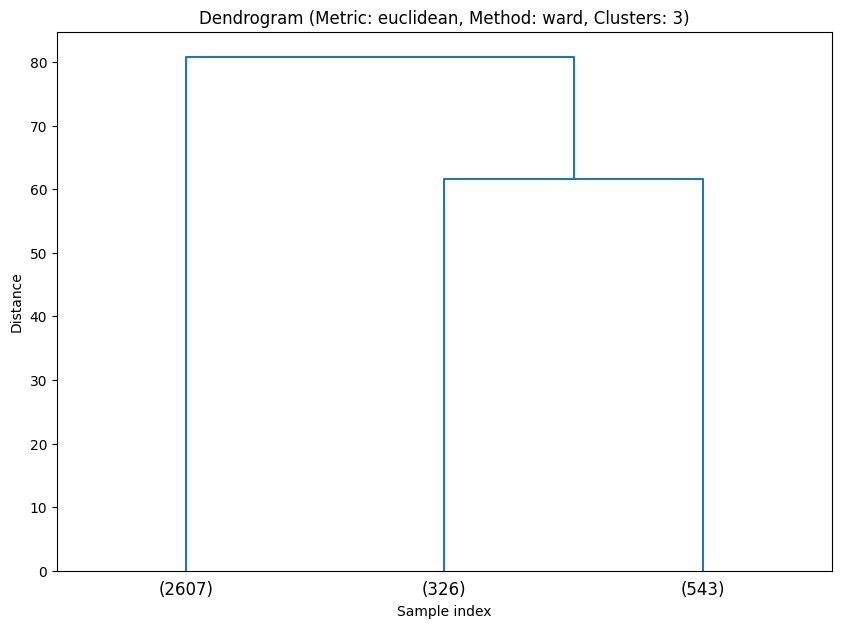

In [19]:
plt.figure(figsize=(10, 7))
dendrogram(linkage(distances, method=result_choice['method']), truncate_mode='lastp', p=int(result_choice['k']))
plt.title(f"Dendrogram (Metric: {result_choice['metric']}, Method: {result_choice['method']}, Clusters: {result_choice['k']})")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()


In [26]:
import numpy as np

# Calculate the centroids of the clusters
centroids = np.zeros((result_choice['k'], scaled_cyclists_df.shape[1]))
for i in range(result_choice['k']):
    centroids[i, :] = scaled_cyclists_df[labels == i + 1].mean(axis=0)

centroids

array([[ 0.29280665, -0.40151463, -0.25585967],
       [-0.97738171,  0.30510063,  2.44537825],
       [-0.81900647,  1.74454112, -0.23971853]])

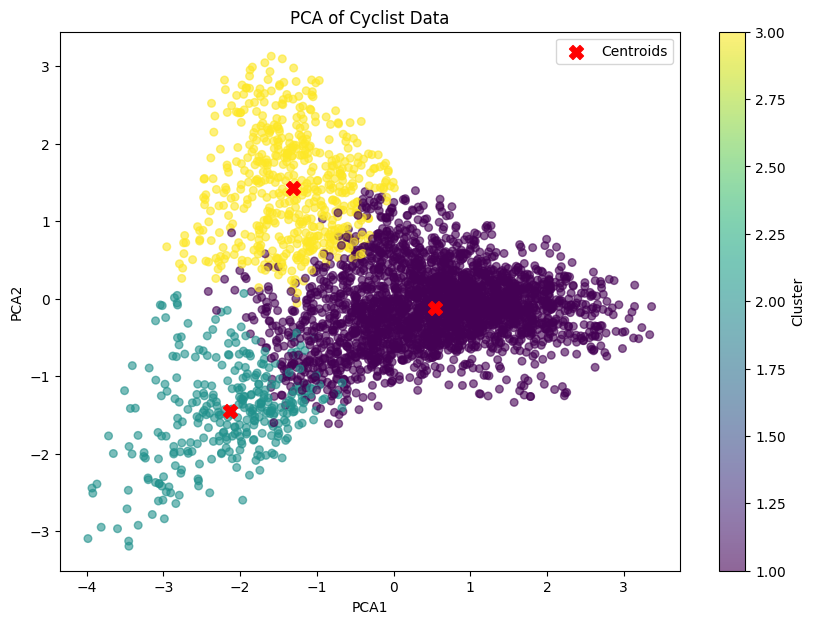

In [27]:
from sklearn.decomposition import PCA

# Perform PCA on the scaled data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_cyclists_df)

# Create a DataFrame with PCA results and cluster labels
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = labels

# Calculate the centroids of the clusters in the PCA space
pca_centroids = pca.transform(centroids)

# Plot the PCA results
plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['Cluster'], cmap='viridis', s=30, alpha=0.6)
plt.scatter(pca_centroids[:, 0], pca_centroids[:, 1], c='red', marker='X', s=100, label='Centroids')
plt.title('PCA of Cyclist Data')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.show()

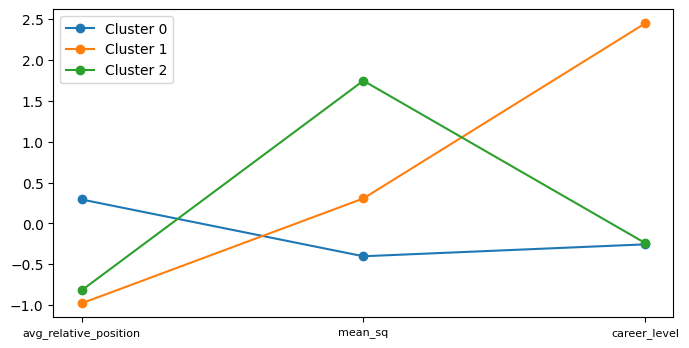

In [28]:
plt.figure(figsize=(8, 4))
for i in range(len(centroids)):
    plt.plot(centroids[i], marker='o', label=f'Cluster {i}')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(len(columns_to_keep)), columns_to_keep, fontsize=8)
plt.legend(fontsize=10)
plt.show()
